In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

録音はsoxを用いて以下のコマンドを用いて，はじめの1秒は環境雑音のために無音，その後に「あ」という母音を発話という形で行った．

録音:`"C:\Program Files (x86)\sox-14-4-2\sox.exe" -d -r 16000 -c 1 -b 16 -t wav speech.wav`

再生:`sox -t wav speech.wav -d`

冒頭の1秒を切り出して保存:`sox -t wav speech.wav silence.wav trim 0 1`

(注)Windowsだとオーディオデバイスを固定する必要があるらしく，`sox -h`で確認後，`set AUDIODRIVER=waveaudio`のように設定する．

In [2]:
import librosa
import librosa.display

import numpy as np
import matplotlib.pyplot as plt

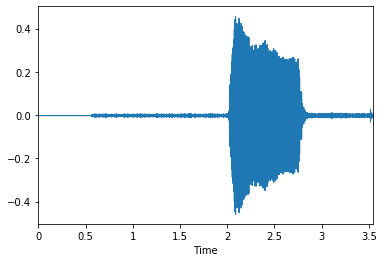

In [3]:
pcm_data, sampling_rate = librosa.load('data/speech.wav', sr=16000)  # 16kHzで読み込み
librosa.display.waveplot(pcm_data, sr=sampling_rate)            # 音声の波形を表示
plt.show()

## 波形データからスペクトルデータへの変換
\[波形データ\] → フレームに区切る(窓かけ) → 周波数成分に変換(Fourier変換) → 周波数ごとのパワーに変換 → \[スペクトルデータ\]

\[スペクトルデータ\] → 微細構造に落とす(メルフィルタバンク) → 対数 → 対数メルスペクトル

音声認識においては位相の情報は使わない．  
(注)スペクトル表現の上限の周波数は，サンプリング周波数の半分である

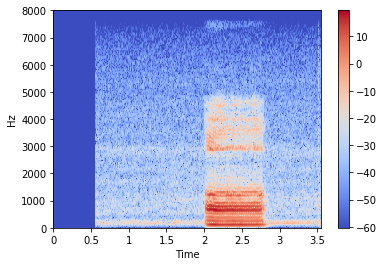

In [8]:
num_bins = 256
frame_size = int(0.02 * sampling_rate)   # フレーム長
frame_shift = int(0.01 * sampling_rate)  # 移動幅

fourier = librosa.stft(pcm_data, n_fft=num_bins*2, win_length=frame_size, hop_length=frame_shift)
power_spectrum = np.abs(fourier) ** 2
log_spectrum = librosa.power_to_db(power_spectrum)

# 描画
librosa.display.specshow(log_spectrum, sr=sampling_rate, hop_length=frame_shift,
                         x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

### フィルタバンク
発声のスペクトログラムには，周波数方向に規則的な縞，すなわち調音構造が見られる．

音声認識においては，この調音構造をわざとなくすためにフィルタバンクという調音構造を無くすフィルタを用いて，スペクトルの外形だけを取り出す．このスペクトルの外形のことをスペクトル包絡という．

調音構造を無くす理由は，音素の識別には，周波数方向に見て，調音構造よりも大きなサイズの山や谷を観察することが重要であるから．

### メルフィルタバンク
高い周波数領域では広く，低い周波数領域では狭くとって重みを掛けた値をフィルタごとに出力するのがフィルタバンクであり，そのフィルタの間隔を人間の聴覚特性に合わせたものをメルフィルタバンクという．

また扱いやすいスペクトル包絡にするために，対数をとって変化の範囲を圧縮したものを対数メルスペクトルという．

母音のフレームでは，概ね2000Hz以下の領域に2個程度の山が見られる．これらを周波数の低い方から第1フォルマント，第2フォルマントと呼ぶ．従来の機械学習では次元数を削減するために，対数メルスペクトルをさらに離散コサイン変換して，13次元程度のメル周波数ケプストラム係数(Mel-Frequency Cepstrum Coefficient, MFCC)を特徴量として用いていた．現在は周波数ごとのパワーをそのまま使われるようになってきた．

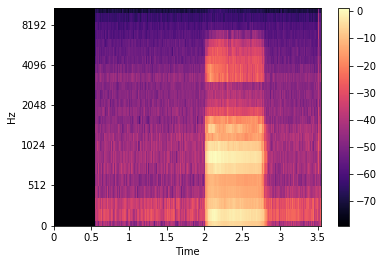

In [6]:
mel_filter_bank = librosa.filters.mel(sampling_rate, num_bins*2, n_mels=24, htk=True)
mel_spectrum = np.dot(mel_filter_bank, power_spectrum)
log_mel_spectrum = librosa.power_to_db(mel_spectrum)

# 描画
librosa.display.specshow(log_mel_spectrum, sr=sampling_rate, hop_length=frame_shift,
                         x_axis='time', y_axis='mel')
plt.colorbar()
plt.show()

### 特徴量の正規化
#### 加法性歪みの除去
加法性歪みとは，本来観測したい信号に足し算の形で重畳する不要な信号である．例えば，発話者のまわりの環境雑音がそれにあたる．走行中の車内音など，定常とみなせる環境雑音は多いので，雑音のパワーを観測値のパワースペクトルから減算することが良く行われる．この手法をスペクトルサブトラクションという．

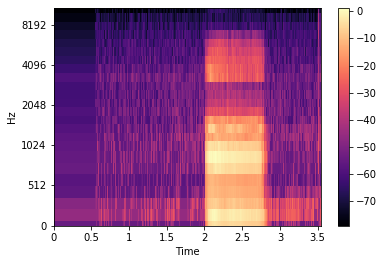

In [11]:
# 環境雑音のパワースペクトルを得る
pcm_data_noise, sampling_rate = librosa.load('data/silence.wav', sr=16000)
fourie_noise = librosa.stft(pcm_data_noise, n_fft=num_bins*2, win_length=frame_size, hop_length=frame_shift)
power_spectrum_noise = np.abs(fourie_noise) ** 2
power_spectrum_noise_mean = np.mean(power_spectrum_noise, axis=1)

# スペクトルサブトラクション
num_dims, num_frames = power_spectrum.shape
power_spectrum_clean = power_spectrum
floor = 0.1  # フロアリング処理係数
for i in range(0, num_dims):
    for t in range(0, num_frames):
        power_spectrum_clean[i, t] = max(power_spectrum[i, t] - power_spectrum_noise_mean[i],
                                         floor * power_spectrum_noise_mean[i])

mel_spectrum_clean = np.dot(mel_filter_bank, power_spectrum_clean)
log_mel_spectrum_clean = librosa.power_to_db(mel_spectrum_clean)

# 描画
librosa.display.specshow(log_mel_spectrum_clean, sr=sampling_rate, hop_length=frame_shift,
                         x_axis='time', y_axis='mel')
plt.colorbar()
plt.show()

#### 乗法性歪みの補正
マイクロフォンまでの距離やアンプゲインの影響は，伝達特性と呼ばれ，入力に対して掛け算の形で効いてくる．これを乗法性歪みという．対数を取れば掛け算は足し算になるので，対数メルスペクトルを対象として処理を行う．

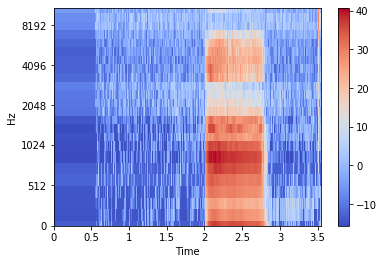

In [12]:
log_mel_spectrum_clean_mean = np.mean(log_mel_spectrum_clean, axis=1)
num_dims, num_frames = log_mel_spectrum_clean.shape
log_mel_spectrum_clean_norm = log_mel_spectrum_clean
for i in range(0, num_dims):
    for t in range(0, num_frames):
        log_mel_spectrum_clean_norm[i, t] = log_mel_spectrum_clean[i, t] - log_mel_spectrum_clean_mean[i]
        
# 描画
librosa.display.specshow(log_mel_spectrum_clean_norm, sr=sampling_rate, hop_length=frame_shift,
                         x_axis='time', y_axis='mel')
plt.colorbar()
plt.show()

### 動的特徴量
上述してきた特徴量はフレーム内での音響的な特徴を表現するもので，静的特徴量と呼ぶ．

これに対して，フレームの前後でどのような変化があったのかに着目した特徴量を動的特徴量と呼ぶ．
前後のフレームの静的特徴量の1階差分を取ったものをΔ特徴量，2階差分を取ったものをΔΔ特徴量と呼ぶ．

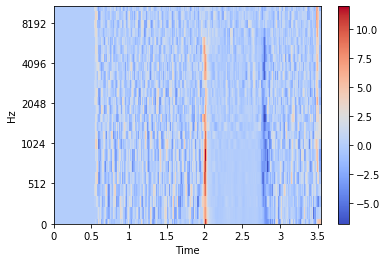

In [13]:
# 1階差分のΔ特徴量
D_log_mel_spectrum_clean = librosa.feature.delta(log_mel_spectrum_clean, width=5, order=1)

# 描画
librosa.display.specshow(D_log_mel_spectrum_clean, sr=sampling_rate, hop_length=frame_shift,
                         x_axis='time', y_axis='mel')
plt.colorbar()
plt.show()

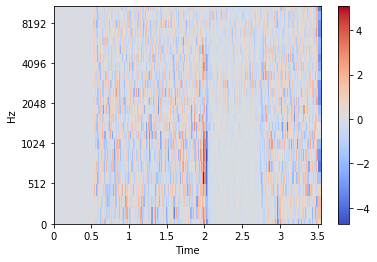

In [15]:
# 2階差分のΔΔ特徴量
DD_log_mel_spectrum_clean = librosa.feature.delta(log_mel_spectrum_clean, width=7, order=2)

# 描画
librosa.display.specshow(DD_log_mel_spectrum_clean, sr=sampling_rate, hop_length=frame_shift,
                         x_axis='time', y_axis='mel')
plt.colorbar()
plt.show()